[View in Colaboratory](https://colab.research.google.com/github/PranY/FastAI_projects/blob/master/TSG.ipynb)

In [0]:
!pip install fastai

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

In [0]:
! pip install kaggle


In [4]:
! pip install tqdm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! ls "drive/My Drive"

In [0]:
! cp drive/My\ Drive/kaggle.json ~/.kaggle/

In [0]:
! kaggle competitions download -c tgs-salt-identification-challenge

In [11]:
! python -c 'import fastai; print(fastai.__version__)'
! python -c 'import fastai; fastai.show_install(0)'

1.0.7


```text
=== Software === 
python version  : 3.6.6
fastai version  : 1.0.7
torch version   : 1.0.0.dev20181019
nvidia driver   : 396.44
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 11441MB | Tesla K80

=== Environment === 
platform        : Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
distro          : #1 SMP Sun Sep 9 02:18:33 PDT 2018
conda env       : Unknown
python          : /usr/bin/python3
sys.path        : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install 

In [12]:
!ls

depths.csv  sample_data		   test.zip   train.zip
drive	    sample_submission.csv  train.csv


In [0]:
# ! rm -r train/
# !rm -r test/

In [0]:
! mkdir train
! mkdir test

In [0]:
! unzip train.zip -d train

In [0]:
! unzip test.zip -d test

In [17]:
! ls train/images | wc -l
! ls train/masks | wc -l
! ls test/images | wc -l

4000
4000
18000


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from tqdm import tqdm_notebook

In [0]:
from fastai import *
from fastai.vision import *
#from fastai.docs import *
import PIL

In [22]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]
num_workers=0
len(train_df)


4000

In [0]:
PATH_X = Path('train/images')
PATH_Y = Path('train/masks')

In [0]:
# def resize2d(fn:PathOrStr, sz) -> Image:
#     img = PIL.Image.open(fn)
#     img = img.resize((sz,sz), PIL.Image.BILINEAR)
#     img.save(fn)

In [0]:
# for l in list(PATH_X.iterdir()):
#   resize2d(l,128)

In [0]:
# for l in list(PATH_Y.iterdir()):
#   resize2d(l,128)

In [0]:
# Reducing mask images to {0,1}

def FormatMask(fn:PathOrStr) -> Image:

    img = PIL.Image.open(fn).convert('L')

    # Let numpy do the heavy lifting for converting pixels to pure black or white
    bw = np.asarray(img).copy()

    # Pixel range is 0...255, 256/2 = 128
    bw[bw < 128] = 0    # Black
    bw[bw >= 128] = 1 # White

    # Now we put it back in Pillow/PIL land
    imfile = PIL.Image.fromarray(bw)
    imfile.save(fn)

In [0]:
for l in list(PATH_Y.iterdir()):
  FormatMask(l)

In [0]:
class ImageMask(Image):
    "Class for image segmentation target."
    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image': return self

    def refresh(self):
        self.sample_kwargs['mode'] = 'bilinear'
        return super().refresh()

    @property
    def data(self)->TensorImage:
        "Return this image pixels as a `LongTensor`."
        return self.px.long()
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, 
        cmap:str='viridis', alpha:float=0.5):
        ax = _show_image(self, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize, alpha=alpha)
        if title: ax.set_title(title)
        
def open_mask(fn:PathOrStr)->ImageMask:
    "Return `ImageMask` object create from mask in file `fn`."
    x = PIL.Image.open(fn).convert('L')
    return ImageMask(pil2tensor(x).float().div_(255))
  
def _show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
                alpha:float=None)->plt.Axes:
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    return ax

torch.Size([101, 101])

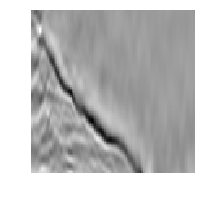

In [36]:
img = next(PATH_X.iterdir())
open_image(img).show()
open_image(img).size

torch.Size([101, 101])

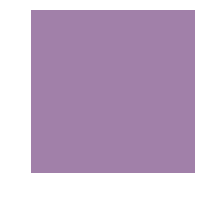

In [37]:
def get_y_fn(x_fn): return PATH_Y/f'{x_fn.name[:-4]}.png'

img_y_f = get_y_fn(img)
open_mask(img_y_f).show()
open_mask(img_y_f).size

torch.Size([3, 101, 101])

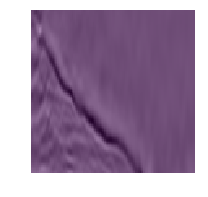

In [38]:
x = open_image(img)
x.show(y=open_mask(img_y_f))
x.shape

In [39]:
open_image(img).shape, open_mask(img_y_f).shape

(torch.Size([3, 101, 101]), torch.Size([1, 101, 101]))

In [0]:
def get_datasets(path):
    x_fns = [o for o in path.iterdir() if o.is_file()]
    y_fns = [get_y_fn(o) for o in x_fns]
    mask = [o>=1000 for o in range(len(x_fns))]
    arrs = arrays_split(mask, x_fns, y_fns)
    return [SegmentationDataset(*o) for o in arrs]


In [41]:
train_ds,valid_ds = get_datasets(PATH_X)
train_ds,valid_ds

(SegmentationDataset of len 3000, SegmentationDataset of len 1000)

In [42]:
x,y = next(iter(train_ds))
x.shape, y.shape, type(x), type(y)

(torch.Size([3, 101, 101]),
 torch.Size([1, 101, 101]),
 fastai.vision.image.Image,
 fastai.vision.image.ImageSegment)

In [0]:
size = 128

In [0]:
def get_tfm_datasets(size):
    datasets = get_datasets(PATH_X)
    tfms = get_transforms(do_flip=True, max_rotate=4, max_lighting=0.2)
    return transform_datasets(train_ds, valid_ds, tfms=tfms, tfm_y=True, size=size, padding_mode='border')

In [0]:
train_tds, *_ = get_tfm_datasets(size)

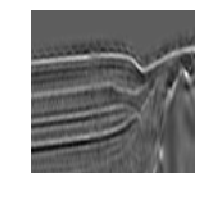

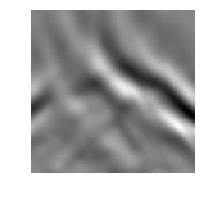

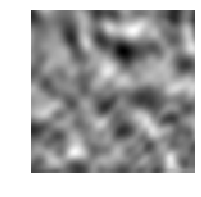

In [46]:
for i in range(0,3):
  train_tds[i][0].show()

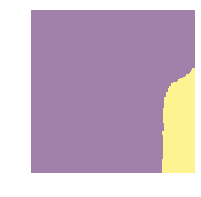

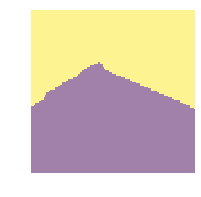

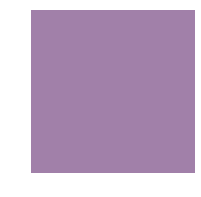

In [47]:
for i in range(0,3):
  train_tds[i][1].show()

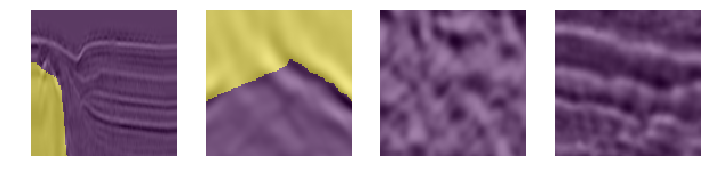

In [48]:
_,axes = plt.subplots(1,4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    imgx,imgy = train_tds[i]
    imgx.show(ax, y=imgy)

In [0]:
default_norm,default_denorm = normalize_funcs( mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
bs = 32

In [0]:
def get_data(size, bs):
    return DataBunch.create(*get_tfm_datasets(size), bs=bs, tfms=default_norm)

In [0]:
data = get_data(size, bs)

In [0]:
#export
def show_xy_images(x:Tensor,y:Tensor,rows:int,figsize:tuple=(9,9)):
    "Shows a selection of images and targets from a given batch."
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()): show_image(x[i], y=y[i], ax=ax)
    plt.tight_layout()

(torch.Size([32, 3, 128, 128]), torch.Size([32, 1, 128, 128]))

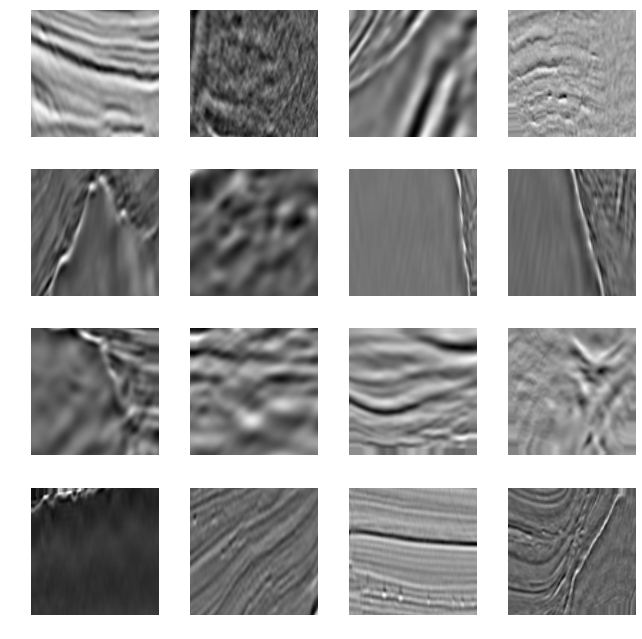

In [57]:
x,y = next(iter(data.train_dl))
x,y = x.cpu(),y.cpu()
x = default_denorm(x)
show_xy_images(x,y,4, figsize=(9,9))
x.shape, y.shape

In [58]:
head = std_upsample_head(2, 512,256,256,256,256)
head

Sequential(
  (0): ReLU()
  (1): StdUpsample(
    (conv): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): ConvTranspose2d(256, 2, kernel_size=(2, 2), stride=(2, 2), bias=False)
)

In [0]:
def dice(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "Dice coefficient metric for binary target"
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return 2. * intersect / union

def accuracy(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "Accuracy"
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [0]:
metrics=[accuracy, dice]

In [0]:
learn = ConvLearner(data, models.resnet34, custom_head=head,
                    metrics=metrics)

epoch  train loss  valid loss  accuracy  dice
1      6.040244  


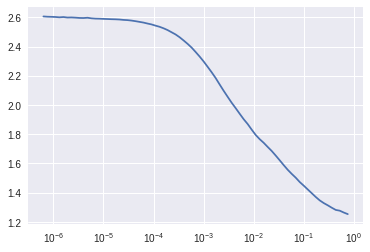

In [64]:
lr_find(learn)
learn.recorder.plot()

In [66]:
learn.loss_func

CrossEntropyFlat()

In [0]:
lr = 1e-1

In [68]:
learn.fit_one_cycle(10, slice(lr))

epoch  train loss  valid loss  accuracy  dice


RuntimeError: ignored

In [69]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 11.6 GB  | Proc size: 2.1 GB
GPU RAM Free: 10883MB | Used: 558MB | Util   5% | Total 11441MB
